In [203]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal


## Exercise 9.1

In [204]:
# Simulation parameters
m = 8               # no. of mics
delta = 0.0425      # microphone spacing
fs = 8e3            # sampling frequency
c = 340             # propagation speed of sound

# some auxiliary values
n = 256             #frame size

In [205]:
# load signals
f = np.load('signals_09.npz')
S = f['S']
Noise = f['Noise']

xM = S + Noise

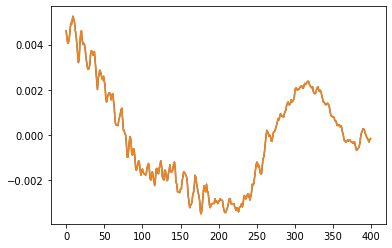

Incident angle of speech is 90.00 degree


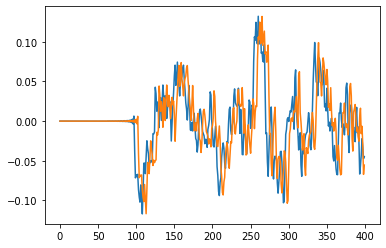

Incident angle of noise is 135.58 degree


In [206]:
def compute_incident_angle(sig_in):
    '''
    Compute the incindent angle of the signal at the beamformer, using the delay between the first
    and the last microphone in the array.
    '''
    global m, c, delta
    # todo: calculate direction of sound incidence
    corr = signal.correlate(sig_in[:, 0], sig_in[:, m - 1], mode="same")
    sig_len = len(sig_in)
    #delay_arr = np.linspace(-0.5 * sig_len / fs, 0.5 * sig_len / fs, sig_len)
    delay_arr = np.arange(-0.5 * sig_len / fs, 0.5 * sig_len / fs, 1/fs)
    delay = delay_arr[np.argmax(abs(corr))]
    #a = delay * c / ((m - 1) * delta)
    inc_ang = np.arccos(delay * c / ((m - 1) * delta))
    #plt.plot(delay_arr, corr)
    plt.plot(sig_in[:400, 0])
    plt.plot(sig_in[:400, 7])
    plt.show()
    return inc_ang*180/np.pi

print("Incident angle of speech is {:4.2f} degree".format(compute_incident_angle(S)))
print("Incident angle of noise is {:4.2f} degree".format(compute_incident_angle(Noise)))

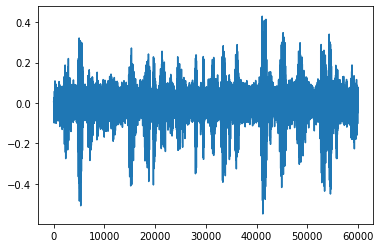

In [207]:
# todo: apply DS-BF (9.4)
# a = 1/m
# k = [(i-1)*delay]
# omega = 2 * np.pi * freq[f] / fs
# b = np.exp(-1j*k*omega)
#
# e = np.array([np.exp(1j*fs*omega*t) for t in tau_vec]).T
# psi[f, a] = np.abs(np.dot(e, b[:, f]))**2
dsbf = S[:, 0] + 1/m*np.sum(Noise, axis=1)
plt.plot(dsbf)
plt.show()
#plt.plot(xM[:, 0])
#plt.show()

<ipython-input-208-b3acb350c462>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ref, f_ref, 10*np.log10(Sxx_ref), **clims)


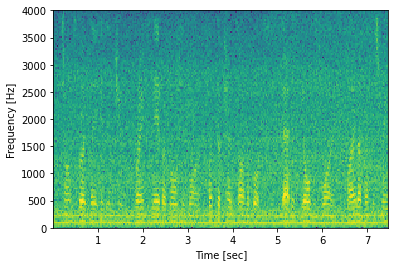

<ipython-input-208-b3acb350c462>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_out, f_out, 10*np.log10(Sxx_out), **clims)


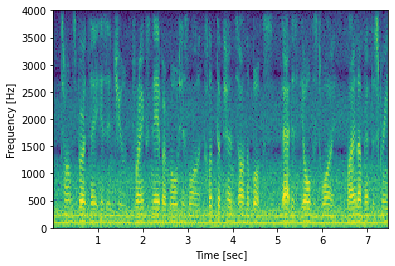

In [208]:
#todo: Plot results
# use same color limits for both plots.
clims = dict(vmin=-120, vmax=-40)
f_ref, t_ref, Sxx_ref = signal.spectrogram(xM[:, 0], fs)
f_out, t_out, Sxx_out = signal.spectrogram(dsbf, fs)
plt.pcolormesh(t_ref, f_ref, 10*np.log10(Sxx_ref), **clims)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()
plt.pcolormesh(t_out, f_out, 10*np.log10(Sxx_out), **clims)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()


In [209]:
# play signals
import sounddevice as sd
#sd.play(S[:, 0], fs)
#sd.play(xM[:, 0], fs)
sd.play(dsbf, fs)


## Exercise 9.2

In [210]:
# Three helper functions
def glob_snr(sig, noise):
    """
    returns the global SNR between sig and noise in dB.
    :param sig:         clean signal
    :param noise:       noise signal
    :return: the global SNR in dB
    """
    global_snr = 10*np.log10(np.dot(sig, sig.T)/np.dot(noise, noise.T))
    return global_snr


def noise_attenuation(reference, filtered, blocks):
    """
    returns the global SNR between sig and noise in dB.
    :param reference:      noise at the microphone
    :param filtered:       filtered noise signal
    :return: the Noise Attenuation in dB
    """
    global n
    noise_at = 10*np.log10(1/blocks*np.sum([np.sum(reference[i*n:(i+1)*n]**2)/np.sum(filtered[i*n:(i+1)*n]**2) for i in range(blocks)]))
    return noise_at


def scale4snr(sig, noise, snr_wanted):
    """
    returns the scaling factor for the noise to obtain wanted global SNR in dB.
    :param sig:         clean signal
    :param noise:       noise signal
    :param snr_wanted:   desired global SNR in dB
    :return: scalar scaling factor a, so that sig + a*noise has the snr_wanted snr
    """
    a = np.sqrt(np.sum(np.square(sig))/(np.sum(np.square(noise))*10**(snr_wanted/10)))
    return a

In [211]:
def sweep_snr(sig, noise):
    global m, n
    na = []
    snr_out = []
    snr_in = []
    for snr in range(-15, 15, 5):
        # todo: mix signals and apply DS BF
        scaled_noise = scale4snr(sig, noise, snr)*noise
        mix = sig + scale4snr(sig, noise, snr)*noise
        dsbf = sig[:, 0] + 1 / m * np.sum(scaled_noise, axis=1)
        snr_in.append(snr)
        #snr_out.append(10 * np.log10(np.sum(np.square(dsbf)) / np.sum(np.square(mix[:, 0]))))
        snr_out.append(glob_snr(sig[:, 0], dsbf-sig[:, 0]))
        na.append(noise_attenuation(mix[:, 0]-sig[:, 0], dsbf-sig[:, 0], int(np.floor(len(sig)/n))))

    # todo: plot results
    plt.plot(np.arange(-15, 15, 5), snr_out, label="SNR out")
    plt.plot(np.arange(-15, 15, 5), na, label="Noise Attenuation")
    plt.grid()
    plt.legend()
    plt.show()

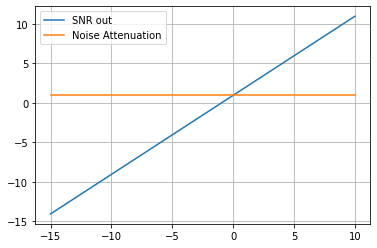

In [212]:
sweep_snr(S, Noise)

## Exercise 9.3

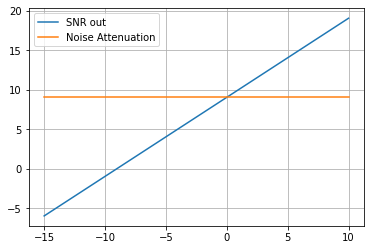

In [213]:
# todo: generate white noise
N_uncorr = np.random.normal(0, 1, (len(S[:, 0]), 8))
sweep_snr(S, N_uncorr)

## Exercise 9.4

In [214]:
def fracdel(inp, delay):
    """
    returns input sequence delayed by delta samples, which can be fractional value. This is achieved by means of a
    fractional-delay filter of degree 2*Noise. The output sequence y is of the same length as the input sequence in.
    :param inp:     input sequence
    :param delay:   time delay
    :param n:       filter length
    :return:        convolved sequence
    """
    pass

In [215]:
# todo: load car noise
carnoise = ...

def sweep_angle(sig, noise):
    global m, delta, c, fs

    # todo: sweep angle, apply DS-BF and evaluate metrics
    pass


In [216]:
sweep_angle(S, carnoise)